In [1]:
#%matplotlib notebook
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
import ipywidgets as ipw
from matplotlib import cm
import ipywidgets as widgets
from scipy import integrate

# Illustration : Crossing a river
This example deal with the case of a person who wants to cross a river in a minimum of time. 


Problem statement:
* the velocity on the ground is 10 km/h
* the swimming velocity is 1 km/h
* the starting point and the ending point are fixed
* the width of the river is fixed (40m)

Based on this problem we will go through the formulation of the optimization method and its resolution. 
The following points have to be addressed : 

* Problem formulation

* Objective 

* Variables 

* Constraints 

* Objective function

* Resolution method


## Problem statement : model formulation
### Where is the river :  model the river
The river is an area wher the velocity is lower.

In [2]:
groung_v = 10.0 / 3.6
swim_v = 1.0 / 3.6

y1_river = 40
y2_river = 80


def world_definition(x, y):
    v = swim_v * np.ones_like(x)
    v[y <= y1_river] = groung_v
    v[y > y2_river] = groung_v
    return v


x = np.linspace(0, 100, 100)
y = np.linspace(0, 120, 150)
x_world, y_world = np.meshgrid(x, y, indexing="xy")
v_world = world_definition(x_world, y_world)

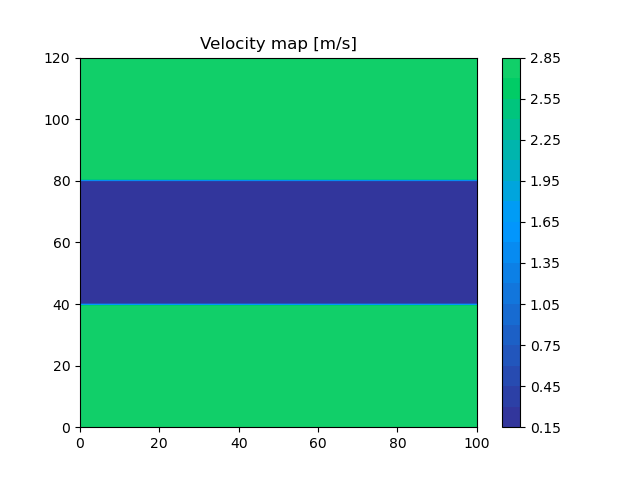

In [3]:
plt.figure()
plt.contourf(x_world, y_world, v_world, 20, cmap=cm.terrain, vmax=10.0)
plt.title("Velocity map [m/s]")
plt.colorbar()
plt.show()

### Defintion of the path

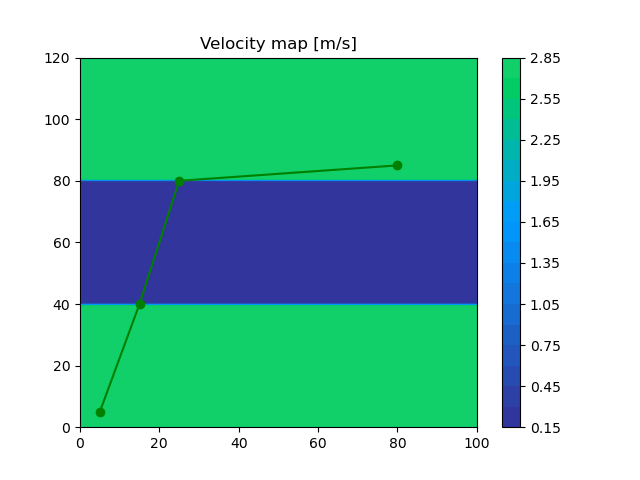

In [4]:
path = np.array([[5.0, 5.0], [15.0, y1_river], [25, y2_river], [80, 85]])

plt.figure()
plt.contourf(x_world, y_world, v_world, 20, cmap=cm.terrain, vmax=10.0)
plt.plot(path[:, 0], path[:, 1], "go-")
plt.title("Velocity map [m/s]")
plt.colorbar()

## Model the river crossing : compute the velocity and the duration to go trougth the path

* first lrt's work on one segment of the path :

In [5]:
def arc_duration(seg, nb_sub=20):
    seg = seg.T
    sub = np.linspace(seg[:, 0], seg[:, 1], nb_sub)
    sub = sub[:-1] + np.diff(sub, axis=0) / 2
    sub_length = np.linalg.norm(np.diff(seg)) / (nb_sub - 1)
    v = world_definition(sub[:, 0], sub[:, 1])
    duration = (sub_length / v).sum()
    return duration, sub, v

In [6]:
# test for one segment of the path
seg = path[:2, :]
duration, sub, v = arc_duration(seg, nb_sub=20)
duration

13.104197800704934

* Now we can work on the full path :

In [7]:
total = 0
for i in range(len(path) - 1):
    seg = path[i : i + 2, :]
    duration, sub, v = arc_duration(seg, nb_sub=20)
    total += duration
    print("segment {0} : {1:0.2f}s".format(i, duration))
print("Total   : {0:0.2f}s".format(total))

segment 0 : 13.10s
segment 1 : 148.43s
segment 2 : 19.88s
Total   : 181.42s


In [8]:
def total_duration(path, blabla=False):
    total = 0.0
    for i in range(len(path) - 1):
        seg = path[i : i + 2, :].copy()
        duration, _, _ = arc_duration(seg, nb_sub=20)
        total += duration
        if blabla:
            print("segment {0} : {1:0.1f}s".format(i, duration))
    if blabla:
        print("Total   : {0:0.1f}s".format(total))
    return total


# test for the path
total_duration(path, blabla=True)

segment 0 : 13.1s
segment 1 : 148.4s
segment 2 : 19.9s
Total   : 181.4s


181.41765015387776

### Widget plot

interactive(children=(FloatSlider(value=30.0, description='x1', step=1.0), FloatSlider(value=30.0, description…

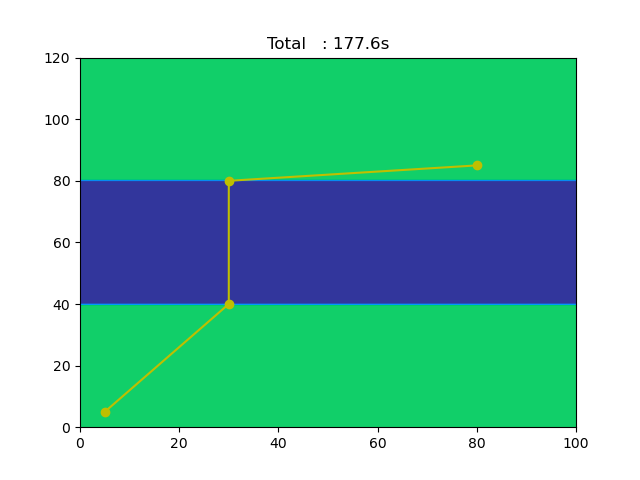

In [11]:
plt.figure()
(l,) = plt.plot(path[:, 0], path[:, 1], "y-o")
plt.contourf(x_world, y_world, v_world, 20, cmap=cm.terrain, vmax=10.0)
title = plt.title("duration")


@ipw.interact(x1=(0.0, 100, 1), x2=(0.0, 100, 1))
def update(x1=30, x2=30):
    path[1, 0] = x1
    path[2, 0] = x2
    t_total = total_duration(path, blabla=False)
    l.set_data(path[:, 0], path[:, 1])
    title.set_text("Total   : {0:0.1f}s".format(t_total))

### What is the optimal solution ?
#### First idea : test all combination 

In [12]:
Nx, Ny = 30, 30
x1 = np.linspace(5, 100, Nx)
x2 = np.linspace(5, 100, Ny)
X, Y = np.meshgrid(x1, x2)
Z = np.zeros_like(X)

for i in range(len(X)):
    for j in range(len(Y)):
        path[1, 0] = X[i, j]
        path[2, 0] = Y[i, j]
        Z[i, j] = total_duration(path, blabla=False)

##### Find the min

In [13]:
x1_min, x2_min = np.where(np.min(Z) == Z)
X_min = X[x1_min, x2_min]
Y_min = Y[x1_min, x2_min]
print(X_min, Y_min)

[67.24137931] [70.51724138]


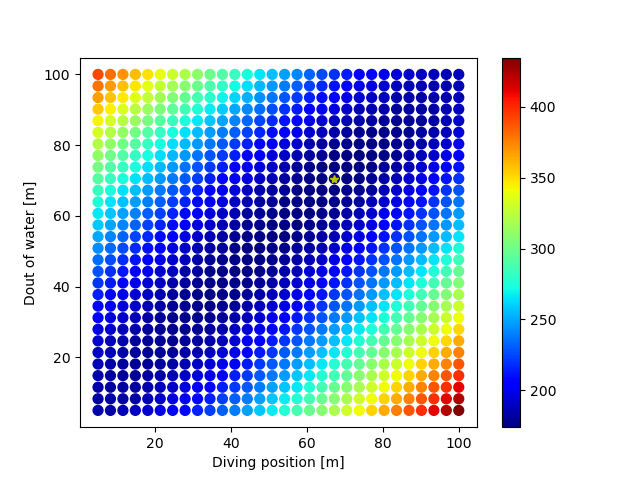

In [14]:
plt.figure()
title = plt.title("")
# plt.contourf(X, Y, Z, 20, cmap=cm.jet)
# plt.colorbar()
# plt.contour(X, Y, Z, 20, cmap=cm.gray)
plt.scatter(X, Y, c=Z, s=50, cmap=cm.jet)
plt.plot(X_min, Y_min, "*y")
plt.colorbar()
plt.xlabel("Diving position [m]")
plt.ylabel("Dout of water [m]")
plt.show()

### Is that realistic with a finer grid ? (or in larger dimension)

In [13]:
%%timeit
total_duration(path, blabla=False)

87.2 µs ± 1.15 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### Usning optimization methode

In [15]:
def cost(X):
    path[1, 0] = X[0]
    path[2, 0] = X[1]
    return total_duration(path, blabla=False)

In [17]:
from scipy import optimize

In [18]:
sol = optimize.minimize(cost, [10.0, 10.0], method="Nelder-Mead")

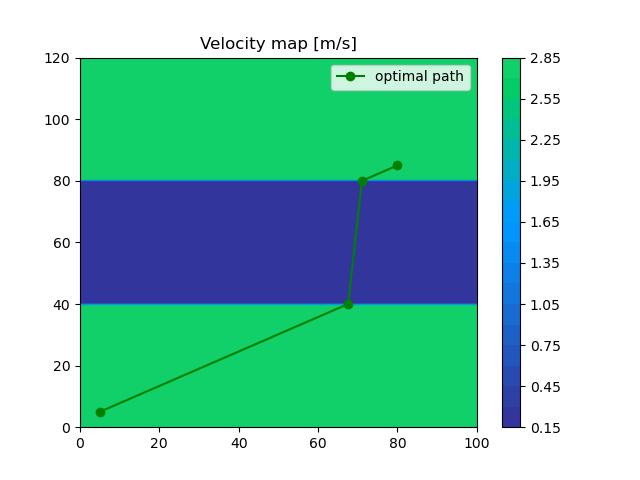

In [19]:
plt.figure()
plt.contourf(x_world, y_world, v_world, 20, cmap=cm.terrain, vmax=10.0)
plt.plot(path[:, 0], path[:, 1], "go-", label="optimal path")
plt.title("Velocity map [m/s]")
plt.legend()
plt.colorbar()

## Crossing another river : higer dimension
The person can swim faster close to the river side.

In [22]:
def world_definition(x, y):
    v = swim_v * np.ones_like(x)
    v = swim_v + (1 - 0.8 * np.cos(2 * np.pi * (y - 60) / 40))
    v[y <= y1_river] = groung_v
    v[y > y2_river] = groung_v
    return v


x = np.linspace(0, 100, 100)
y = np.linspace(0, 120, 150)

x_world, y_world = np.meshgrid(x, y, indexing="xy")
v_world = world_definition(x_world, y_world)

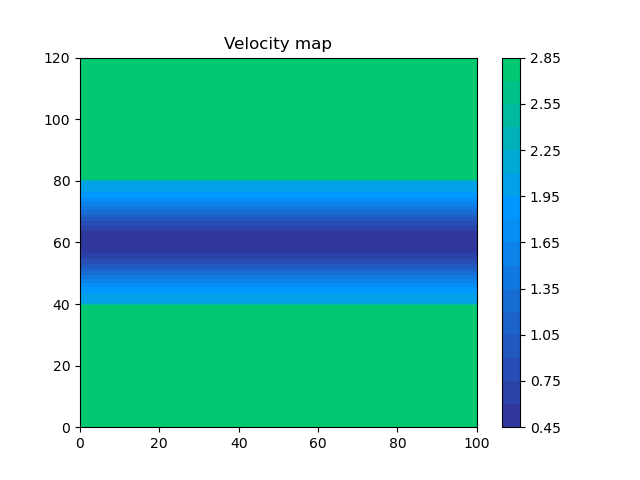

In [23]:
plt.figure()
plt.contourf(x_world, y_world, v_world, 20, cmap=cm.terrain, vmax=10.0)
plt.title("Velocity map")
plt.colorbar()
plt.show()

Is that still relevant to go straight ?

### Add more control points

In [33]:
path_init = np.linspace([5.0, 5.0], [80.0, 100.0], 10)
path = np.copy(path_init)

In [34]:
def cost_n_points(X):
    for i in range(len(X)):
        path[i + 1, 0] = X[i]
    return total_duration(path, blabla=False)

In [35]:
init_guess = np.copy(path_init[:-2, 0])
sol = optimize.minimize(cost_n_points, init_guess, method="Nelder-Mead")
X = sol.x
for i in range(len(X)):
    path[i + 1, 0] = X[i]

In [27]:
sol

 final_simplex: (array([[16.83791316, 28.67591997, 40.51384494, 47.80953696, 50.42795006,
        52.16756458, 57.19058634, 68.1620574 ],
       [16.83789628, 28.67587562, 40.51384023, 47.80954722, 50.42795271,
        52.16757564, 57.19059337, 68.16202116],
       [16.83790611, 28.67587144, 40.51383628, 47.80955586, 50.42794133,
        52.16756542, 57.19058828, 68.16207177],
       [16.83795222, 28.67596532, 40.51391237, 47.80959797, 50.42799519,
        52.16760652, 57.19061365, 68.16204804],
       [16.8379846 , 28.67592696, 40.51387185, 47.80954194, 50.42794728,
        52.16757052, 57.19060712, 68.16207541],
       [16.83789903, 28.67590601, 40.51385712, 47.80954919, 50.42792651,
        52.16754029, 57.19054481, 68.16203475],
       [16.83792172, 28.67589353, 40.51391567, 47.80959502, 50.42799163,
        52.16758021, 57.19059285, 68.16205365],
       [16.83792472, 28.67591716, 40.51390145, 47.80957557, 50.42798778,
        52.16760285, 57.19064907, 68.16208041],
       [16.8379

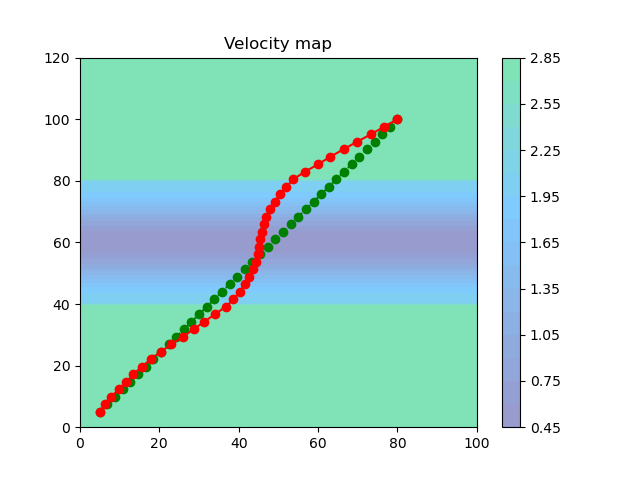

In [32]:
plt.figure()
plt.contourf(x_world, y_world, v_world, 20, cmap=cm.terrain, vmax=10.0, alpha=0.5)
plt.plot(path_init[:, 0], path_init[:, 1], "o:g")
plt.plot(path[:, 0], path[:, 1], "o-r")
plt.title("Velocity map")
plt.colorbar()

## Add constrainte : Crossing a river with a crocodile 

In [36]:
# Low velocity
def invexp(x, y, tau, cx, cy):
    return np.exp(-(((x - cx) / tau) ** 2) - ((y - cy) / tau) ** 2)


def world_definition(x, y):
    v = swim_v * np.ones_like(x)
    v = swim_v + (1 - 0.8 * np.cos(2 * np.pi * (y - 60) / 40))
    tau = 5
    v = v * ((1 + 0.1) - invexp(x, y, tau, 50, 60))
    v[y <= y1_river] = groung_v
    v[y > y2_river] = groung_v
    return v


x = np.linspace(0, 100, 100)
y = np.linspace(0, 120, 150)

x_world, y_world = np.meshgrid(x, y, indexing="xy")
v_world = world_definition(x_world, y_world)

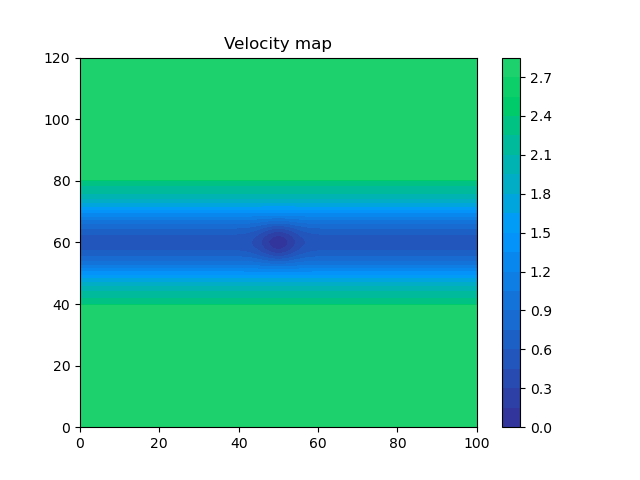

In [37]:
plt.figure()
plt.contourf(x_world, y_world, v_world, 20, cmap=cm.terrain, vmax=10.0)
plt.title("Velocity map")
plt.colorbar()
plt.show()

### With 2 parametres  (2D Problems)

In [38]:
path = np.array([[5.0, 5.0], [15.0, y1_river], [25, y2_river], [80, 85]])

In [39]:
Nx, Ny = 25, 25
x1 = np.linspace(5, 100, Nx)
x2 = np.linspace(5, 100, Ny)
X, Y = np.meshgrid(x1, x2)
Z = np.zeros_like(X)
for i in range(len(X)):
    for j in range(len(Y)):
        path[1, 0] = X[i, j]
        path[2, 0] = Y[i, j]
        Z[i, j] = total_duration(path, blabla=False)

In [40]:
x1_min, x2_min = np.where(np.min(Z) == Z)
X_min = X[x1_min, x2_min]
Y_min = Y[x1_min, x2_min]
print(X_min, Y_min)

[56.45833333] [72.29166667]


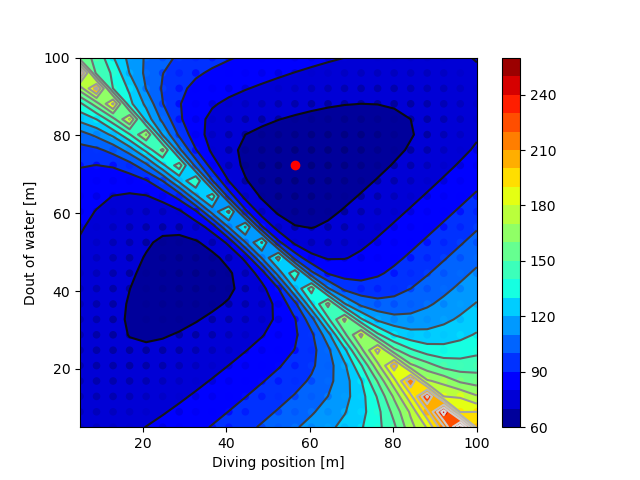

In [41]:
plt.figure()
title = plt.title("")
plt.contourf(X, Y, Z, 20, cmap=cm.jet)
plt.colorbar()
plt.contour(X, Y, Z, 20, cmap=cm.gray)
plt.scatter(X, Y, c=Z, s=20, cmap=cm.jet)
plt.plot(X_min, Y_min, "or")
plt.xlabel("Diving position [m]")
plt.ylabel("Dout of water [m]")
plt.show()

### With N parametres  (ND Problems)

In [46]:
N = 20
path_init = np.linspace([5.0, 5.0], [80.0, 100.0], N)
path = np.copy(path_init)


def cost_n_points(X):
    for i in range(len(X)):
        path[i + 1, 0] = X[i]
    return total_duration(path, blabla=False)

In [47]:
init_guess

array([35.6081822 , 73.70113568, 47.24926034, 45.78605749, 72.63695538,
        6.42471729, 11.25877951, 33.1906817 ])

In [48]:
init_guess = 5 + np.random.rand(path_init[:-2, 0].shape[0]) * 80.0
path_init[1:-1, 0] = init_guess
sol = optimize.minimize(cost_n_points, init_guess, method="Nelder-Mead")
X = sol.x
for i in range(len(X)):
    path[i + 1, 0] = X[i]

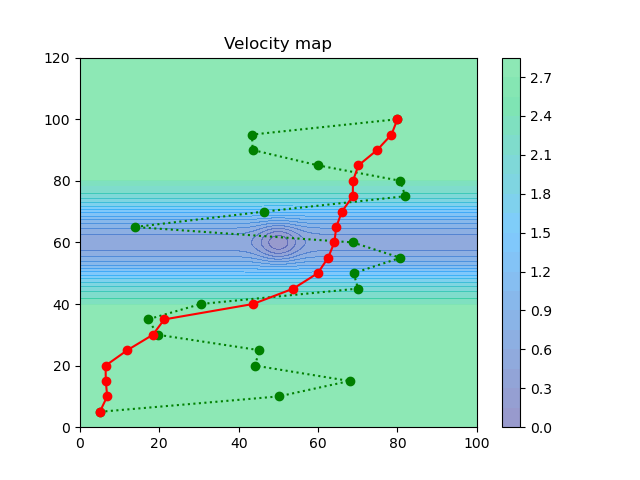

In [49]:
plt.figure()
plt.contourf(x_world, y_world, v_world, 20, cmap=cm.terrain, vmax=10.0, alpha=0.5)
plt.plot(path_init[:, 0], path_init[:, 1], "o:g")
plt.plot(path[:, 0], path[:, 1], "o-r")
plt.title("Velocity map")
plt.colorbar()